<a href="https://colab.research.google.com/github/sayakpaul/Hello-TensorFlow/blob/master/Hello%2C_TensorFlow_bit_ly_ht_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Colab notebook accompanies this talk: http://bit.ly/gdg-goa-20.

If you do not know how to use this particular environment (Colab), please follow these instructions: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/#1. 

In [3]:
# Our big elephant in the room
import tensorflow as tf
print(tf.__version__)

2.2.0-rc1


The following code is referred from here: https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO.

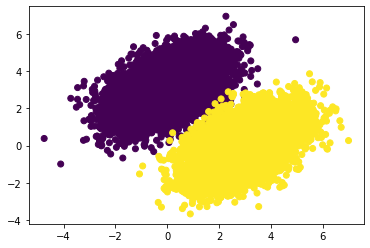

In [4]:
# Import other libraries
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare a dataset.
num_samples = 10000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])

We now have data where we 1000 data points having a label of 1 and 1000 data points having a label of 0. So, in total we have 2000 data points labeled in two unique classes (0 and 1). The shape of our data is **(2000, 2)**. 

In the [deck](http://bit.ly/gdg-goa-20), we discussed that we need to apply some transformations to uncrumple the above data. The transformations were of the following form:

![](https://i.ibb.co/rcXVwt3/Screen-Shot-2020-03-28-at-9-18-39-AM.png)

Let's generate $W$ and $b$.

In [0]:
# This is our weight matrix
w = tf.Variable(tf.random.uniform(shape=(2, 1)))
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(1,)))

In [6]:
# Preview of the weights
print(w.numpy())

[[0.22532213]
 [0.7545028 ]]


Why did we generated the weights to be of shape **(2, 1)** (2 rows and 1 column)? 

**To make matrix multiplication work!**

Remember that, our input data is of shape **(2000, 2)**. For matrix multiplication to work the [shape compatibility rule](https://www.varsitytutors.com/hotmath/hotmath_help/topics/compatible-matrices) must follow. In this case, if we multiply our input data with the weights we would get an array of shape **(2000, 1)**. 

In [7]:
# We first need to convert NumPy array to TensorFlow tensors
features = tf.convert_to_tensor(features, dtype=tf.float32) 
# Affine trasnform
tf.matmul(features, w) + b

<tf.Tensor: shape=(20000, 1), dtype=float32, numpy=
array([[1.4310477],
       [1.2830482],
       [1.8315872],
       ...,
       [0.4527592],
       [0.0724498],
       [1.741094 ]], dtype=float32)>

The trasnformation we just applied is also called **Affine Transformation**. Let's see how well did we do. 

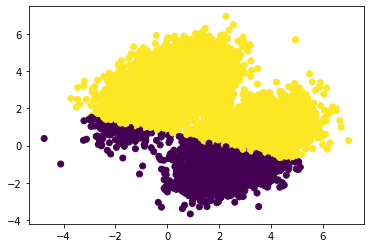

In [9]:
predictions = tf.matmul(features, w) + b
plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0] > 0.5)

In [10]:
predictions.numpy()

array([[1.4310477],
       [1.2830482],
       [1.8315872],
       ...,
       [0.4527592],
       [0.0724498],
       [1.741094 ]], dtype=float32)

**Terrible!** Isn't it? So, where can we go from here? 

> A very naive approach would be to adjust the parameters manually and see how well are we doing. 

Can't we be better than that? If yes, how? 

Think how you learn. Let's say you are learning about prepositions in English Grammar. To better aid your learning, you make **use of the errors** that you make in the beginning and try to focus on the areas that need improvements. 

So, if we were to do something similar here, we first need to be able to make use of the errors we are making. 

> How do we calculate that error? 

From the above cell, we got our `predictions`. Our labels are stored in the `labels` array. So, we can compute the difference between `labels` and `predictions` to see how far off we are from the desired values. We do this in the following way (the reasons are not important at this point):
- Take the absolute difference between `labels` and `predictions`: `abs_diff = labels - predictions`.
- Square the difference: `sqr_diff = tf.square(abs_diff)`.
- Compute the mean: `tf.reduce_mean(sqr_diff)`. 

If we tie the above together, we get the following - 

In [0]:
# Calculate the error (Mean Squared Error)
tf.reduce_mean(tf.square(labels - predictions)).numpy()

0.6362906

Our objective is to ***minimize the above quantity***. 

> After calculating the error in the above way, how do we use this error to inform our system how good/bad it did? 

We cannot change the values of the input data, we have only the parameters to change to minimize the error. Now, we expressed the error in terms of a function - **Mean Squared Error**. Error is referred to as Loss, sometimes interchangeably, sometimes they are different. From now on, we will use Loss. 

*Our predictions are dependent on the parameters* (recall the euqations stated above). To find the **minimum value of this function that is dependent on the labels and predictions**, we need to **find the derivative of this function with respect to the parameters** to know the direction in which we would need to proceed.


The border line is ***we would need to nudge the parameters to minimize the function***. 

Let's write different modules to handle the above things. 

In [0]:
LEARNING_RATE = 0.01

# Affine transform
def compute_predictions(features):
    return tf.matmul(features, w) + b

# Loss
def compute_loss(labels, predictions):
    return tf.reduce_mean(tf.square(labels - predictions))

def minimize_loss(x, y):
    with tf.GradientTape() as tape:
        # Transform data and compute the loss
        predictions = compute_predictions(x)
        loss = compute_loss(y, predictions)
        
        # Compute the derivative/gradients
        dloss_dw, dloss_db = tape.gradient(loss, [w, b])

    # Update the parameters and return loss
    w.assign_sub(LEARNING_RATE * dloss_dw)
    b.assign_sub(LEARNING_RATE * dloss_db)
    return loss

`LEARNING_RATE` helps to accelerate the minimization process. 

Let's now apply it to our data. 

In [0]:
# Prepare a dataset.
num_samples = 10000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

We shuffle the data points to make sure our system does not learn any ordering bias that might be there in the data points.

In [0]:
# Shuffle the data.
indices = np.random.permutation(len(features))
features = features[indices]
labels = labels[indices]

Instead of computing the loss on each data points and then update the parameters accordingly, we will do it in a ***batch-wise manner***. We can easily do so by - 

In [0]:
# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

In [16]:
# Minimize the loss function
for epoch in range(10):
    for step, (x, y) in enumerate(dataset):
        loss = minimize_loss(x, y)
    print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 0.0784
Epoch 1: last batch loss = 0.0798
Epoch 2: last batch loss = 0.0242
Epoch 3: last batch loss = 0.0278
Epoch 4: last batch loss = 0.0369
Epoch 5: last batch loss = 0.0372
Epoch 6: last batch loss = 0.0173
Epoch 7: last batch loss = 0.0255
Epoch 8: last batch loss = 0.0324
Epoch 9: last batch loss = 0.0230


Notice that the loss value is also decreasing - we are minimizing the loss function!

How did we do? 

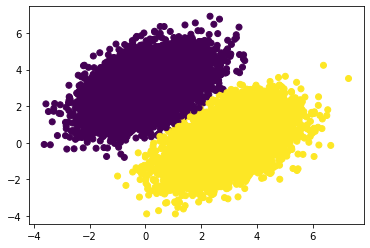

In [17]:
predictions = compute_predictions(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0] > 0.5)

Look at that! 😍 

But, we can do the above with following lines of code - 

In [0]:
# Stuff to minimize the loss function
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=(2,)))
model.compile(optimizer='sgd', loss='mean_squared_error')

In [19]:
# Minimize the loss function
model.fit(dataset, epochs=10)

Epoch 1/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0968
Epoch 2/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0412
Epoch 3/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0332
Epoch 4/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0290
Epoch 5/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0271
Epoch 6/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0262
Epoch 7/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0258
Epoch 8/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0254
Epoch 9/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0253
Epoch 10/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0251


How did we do here? 

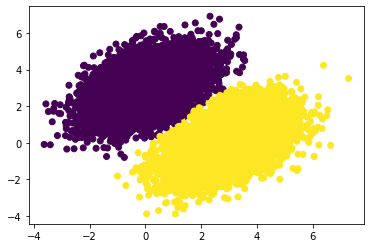

In [20]:
predictions = model.predict(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0] > 0.5)

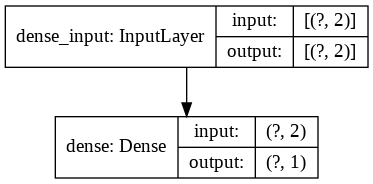

In [0]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)